### Import neccessary Libraries and utilities functions

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import gc
from datetime import datetime
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import sklearn
import catboost
import lightgbm

# Other Libraries
from sklearn.model_selection import (StratifiedShuffleSplit, KFold, StratifiedKFold, train_test_split,
                                        cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,
                             classification_report, roc_curve, roc_auc_score, confusion_matrix)
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import warnings
from sklearn import utils
warnings.filterwarnings("ignore")

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Pick columns with unique values between 1 and 50
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))
    plt.figure(figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(columnDf.dtype, np.number):
            valueCounts = columnDf.value_counts()
            ax = valueCounts.plot.bar()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        else:
            ax = columnDf.hist()
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1, w_pad=1, h_pad=1)
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Load Data

In [ ]:
# Install gdown
!pip install -q gdown

import gdown
import pandas as pd
import hashlib

shared_link = 'https://drive.google.com/file/d/1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH/view?usp=sharing'

file_id = shared_link.split('/')[-2]
dataset_path = 'https://drive.google.com/uc?id=' + file_id

# Download the file
output = '/content/creditcard.csv'
gdown.download(dataset_path, output, quiet=False)

# Read the CSV file
data = pd.read_csv(output)
data.dataframeName = 'creditcard.csv'
nRow, nCol = data.shape

# Print the number of rows and columns
print(f'There are {nRow} rows and {nCol} columns')

Downloading...
From (original): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH
From (redirected): https://drive.google.com/uc?id=1aKYVEOIZZruwHVeUPQ46dm15HJAIEJJH&confirm=t&uuid=6b9c11f7-0ca1-4f44-a3b3-ed8d2dec3dc6
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 79.9MB/s]


There are 284807 rows and 31 columns


### Evaluatory Data Analysis

In [ ]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


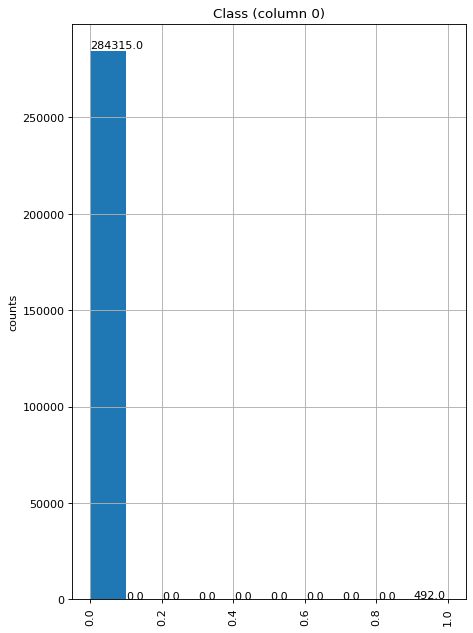

In [ ]:
plotPerColumnDistribution(data, 2, 1)

We could see that the distributions of class is vastly imbalanced with class 1 is much lower than that of class 0.


In this part, we could see that there are about only 492 points in class 1 with 284807 total data points, which means the class 1 only accounts for 0.172% of the total dataset. We need to implement other technique to handle this data imbalance.

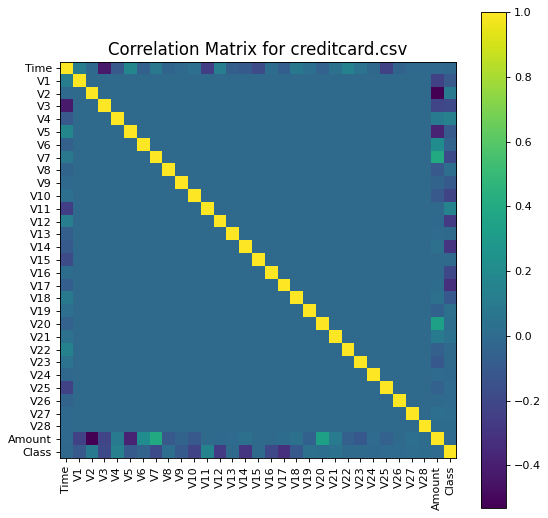

In [ ]:
plotCorrelationMatrix(data, 8)

#### Analysis of Correlation Matrix for Credit Card Transactions Dataset

##### Insights from the Correlation Matrix


1. **Correlation Strength**:
   - The color intensity ranges from dark blue (indicating negative correlation) to bright yellow (indicating strong positive correlation).
   - Most of the off-diagonal elements appear to be closer to dark blue or green, suggesting weak to moderate correlations between the majority of the features.

2. **Principal Components (V1-V28)**:
   - Since V1 to V28 are principal components derived from PCA, they are designed to be uncorrelated with each other.
   - The visualization confirms this, as the off-diagonal elements for these components are generally not bright yellow, indicating low to no correlation.

3. **Time and Amount**:
   - **Time**: The correlations between Time and the other variables (including PCA components and Amount) appear weak, suggesting that the Time variable does not have a strong linear relationship with other features.
   - **Amount**: Similarly, Amount does not show strong correlations with other features, except possibly a slight correlation with some components, which can be explored further numerically.

4. **Class Variable**:
   - This is the target variable indicating fraud (1) or non-fraud (0). Its correlations with other features are essential for understanding relationships.
   - The matrix indicates that the correlations between Class and other features are generally low. This can be seen from the darker colors in the last row and column of the matrix, suggesting that no single feature has a strong linear relationship with the Class.

###### Key Takeaways

- **Low Correlation Between Features**:
  - Most features do not exhibit strong correlations with each other, aligning with the expectation from PCA-transformed data. This is beneficial for certain machine learning models that assume feature independence.

- **Weak Correlation with Class**:
  - The target variable (Class) shows low correlation with individual features, indicating that a combination of features, rather than any single feature, will likely be necessary to detect fraud accurately.

- **Modeling Implications**:
  - Given the low individual correlations, models like logistic regression might not perform as well without feature engineering or dimensionality reduction.
  - Complex models like ensemble methods (e.g., Random Forest, Gradient Boosting) might be better suited to capture the subtle interactions between features for predicting fraud.

- **Notable results**:

  - Certain correlations exist between some features and:
      - Time:
        - Inverse correlation with V3.
      - Amount:
        - Direct correlation with V7 and V20.
        - Inverse correlation with V2 and V5.

We will plot this to see the correlation




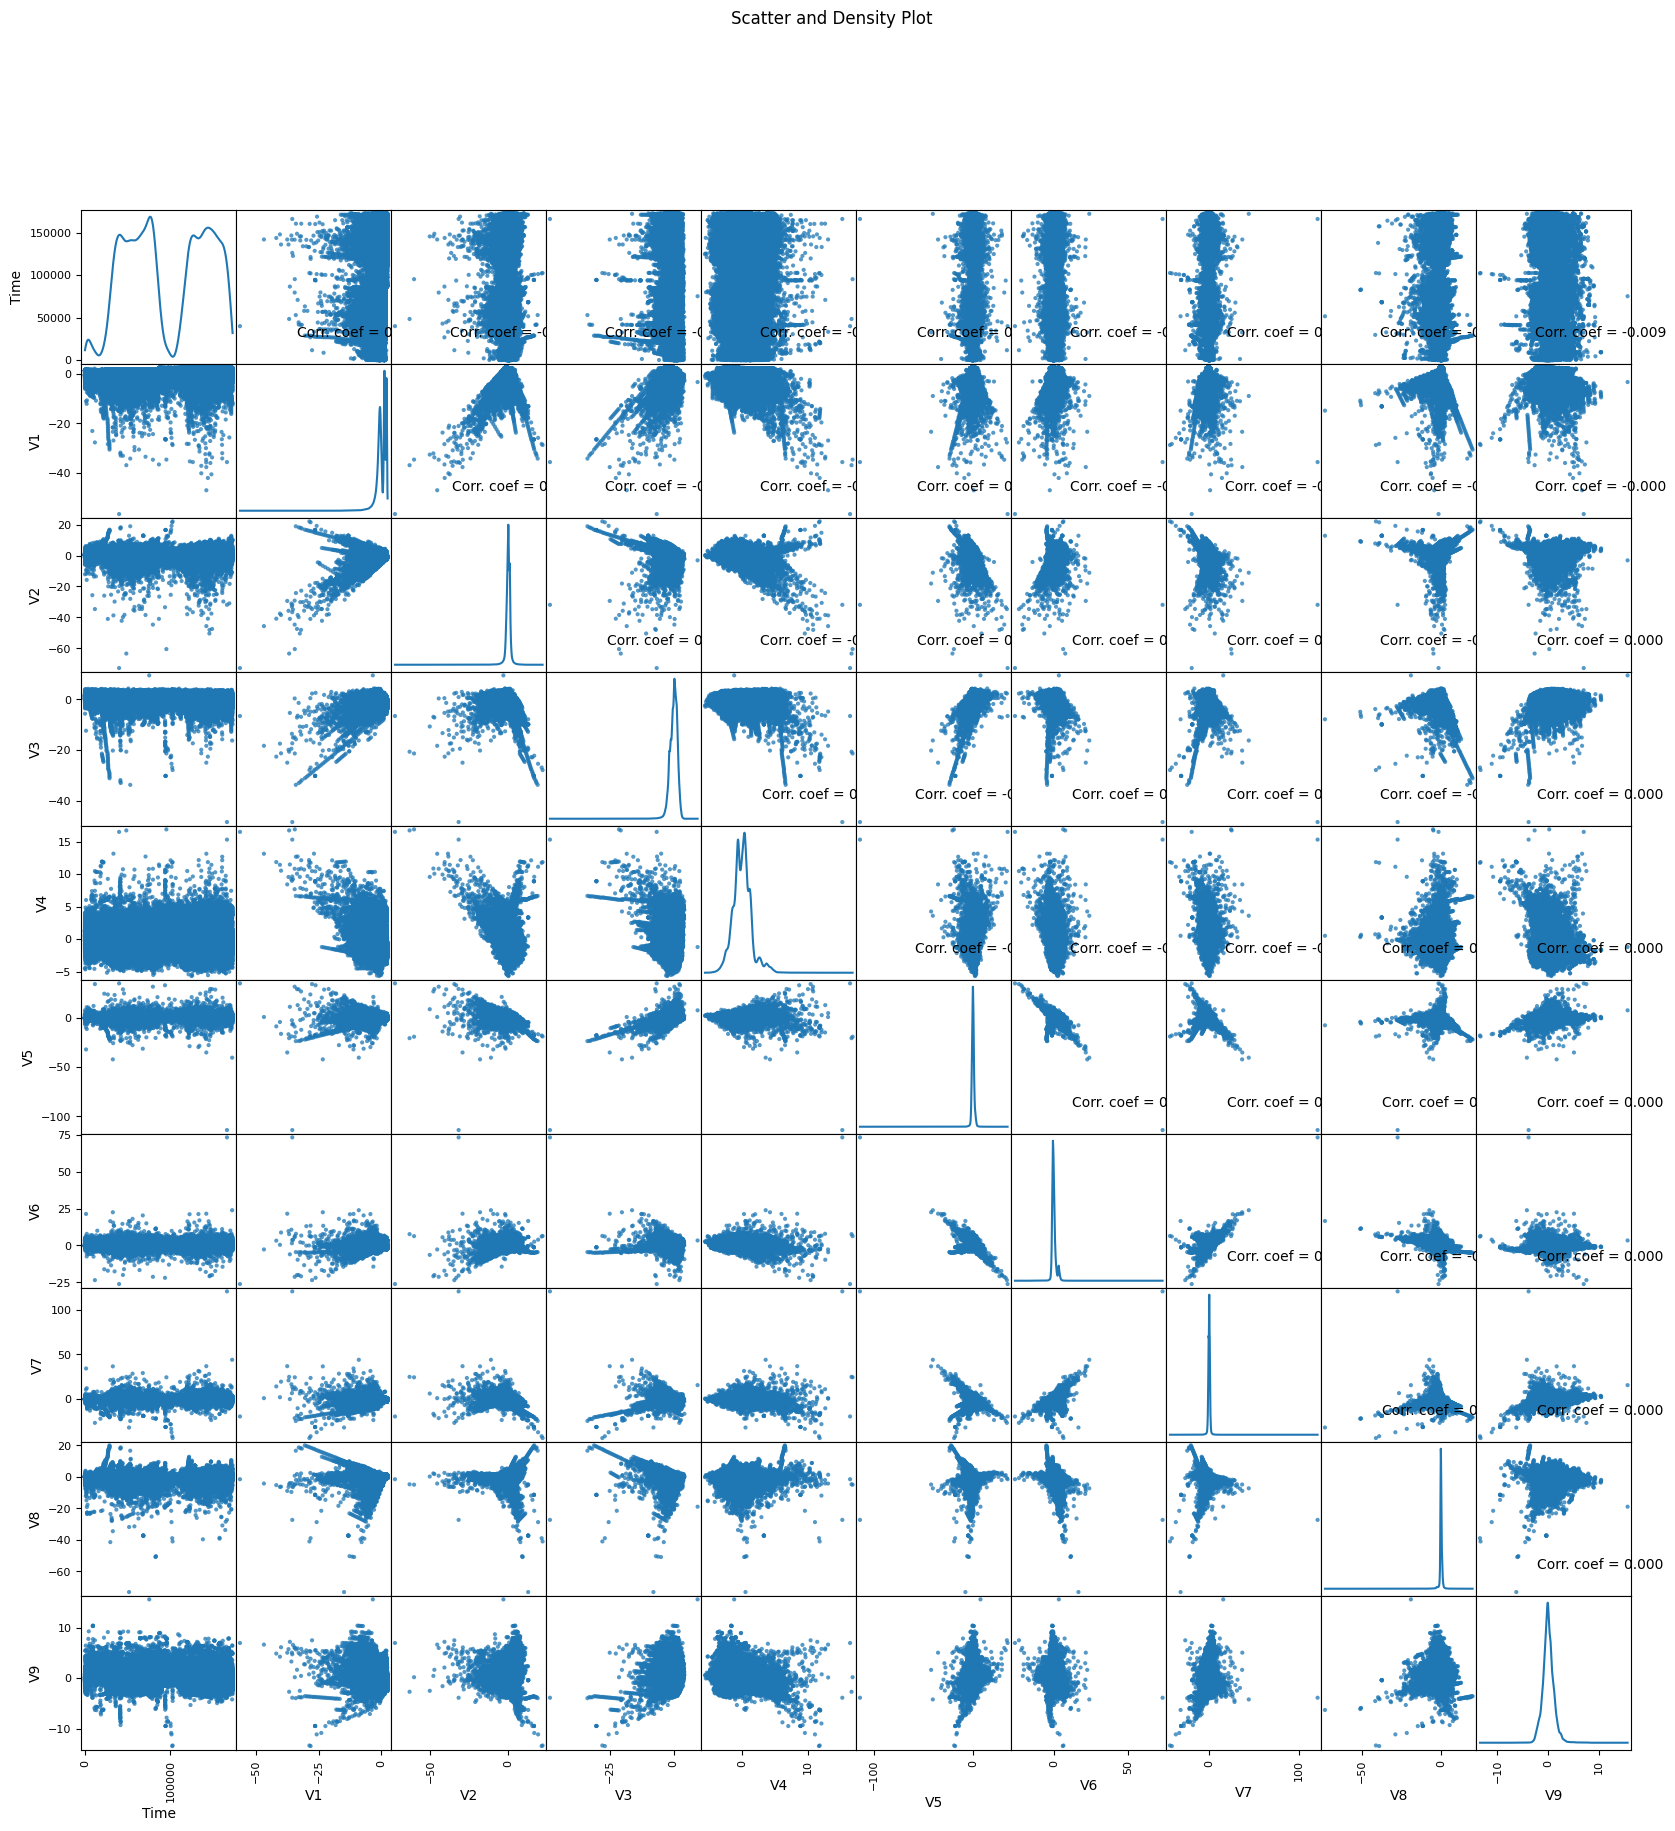

In [ ]:
plotScatterMatrix(data, 20, 10)

We could not see much from the graph, but did notice some interesting correlation between features, next we are going to have a closer look onto it.

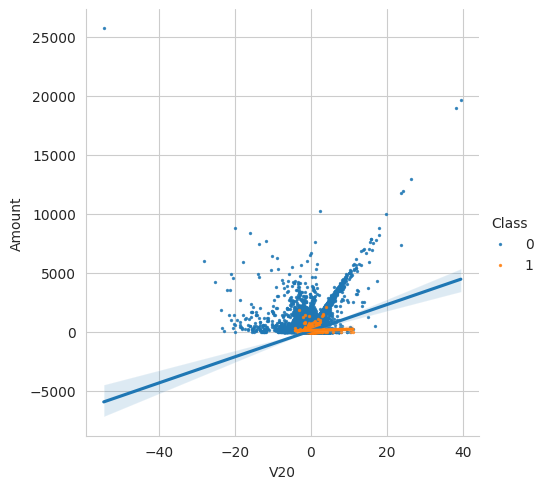

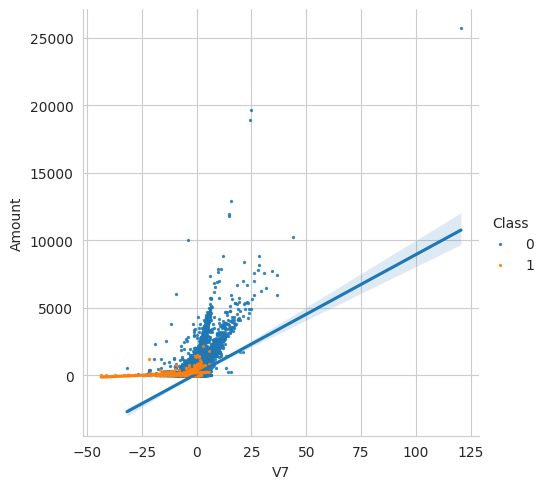

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two pairs of features are correlated:

* For Class 0, the regression lines have a positive slope.
* For Class 1, the regression lines have a smaller positive slope.

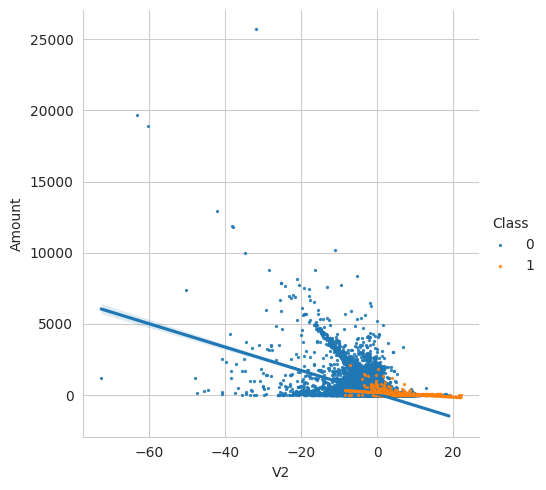

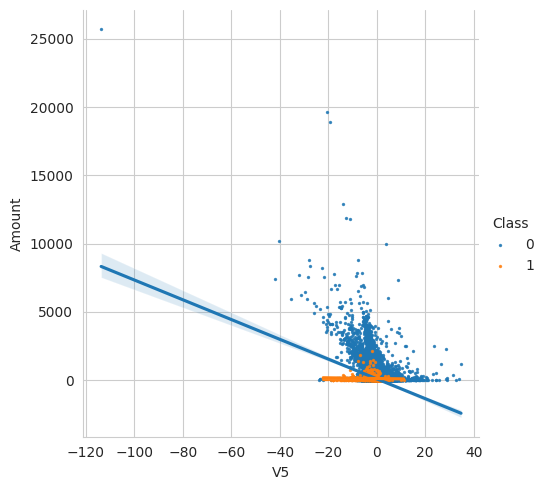

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two pairs of features are inversely correlated:
* For Class 0, the regression lines have a negative slope.
* For Class 1, the regression lines have a very small negative slope.

We could see that all the features are somewhat correlated, therefore, it is not advised that we remove and features from the dataset when do the training.

#### Transaction vs. Time

In [ ]:
# Extract 'Time' data for non-fraud and fraud transactions
time_not_fraud = data[data['Class'] == 0]['Time']
time_fraud = data[data['Class'] == 1]['Time']

time_data = [time_not_fraud, time_fraud]
labels = ['Non-Fraudulent', 'Fraudulent']

custom_colors = ['#2ca02c', '#d62728']

# Generate the distribution plot with custom colors
fig = ff.create_distplot(time_data, labels, show_hist=False, show_rug=False, colors=custom_colors)

fig.update_layout(
    title='Density Plot of Credit Card Transactions Over Time',
    xaxis_title='Time (seconds)'
)

# Display the plot
iplot(fig, filename='time_density_plot')

Unlike valid transactions, which are concentrated during typical business hours, fraudulent transactions are evenly spread throughout the entire day and night. This includes times with low legitimate activity, such as nighttime in the European timezone.

#### Detail of time distribution of both classes transaction

Create a new 'Hour' column by applying a lambda function to the 'Time' column, which computes the hour for each timestamp and rounds it down.

In [ ]:
data['Hour'] = data['Time'].apply(lambda x: np.floor(x / 3600))

# Group data by 'Hour' and 'Class' columns, then calculate various statistics
tmp = data.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
print(df[df["Class"]==1]["Hour"].count())
df.head()

46


,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


We will creates a visual representation of the total transaction amounts over time for both non-fraudulent and fraudulent transactions. We will initializes a figure with two side-by-side subplots of fraud and non-fraud data. This visualization helps in comparing the transaction patterns between non-fraudulent and fraudulent transactions over time.

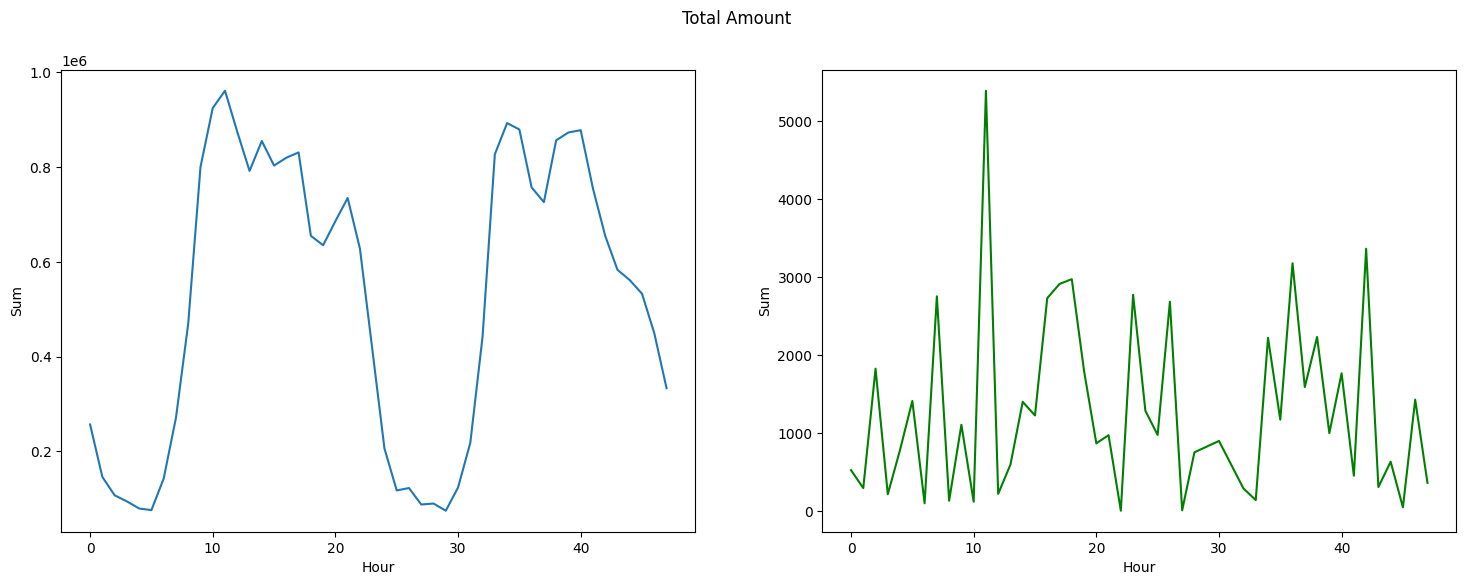

In [ ]:
# Create subplots with two axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

s = sns.lineplot(ax=ax1, x="Hour", y="Sum", data=df.loc[df.Class == 0])
s = sns.lineplot(ax=ax2, x="Hour", y="Sum", data=df.loc[df.Class == 1], color="green")
plt.suptitle("Total Amount")
plt.show()

- Left Graph (Non-fraudulent): This graph shows the total transaction amount over time. There is a noticeable pattern where the amount rises and falls, with peaks around certain hours, indicating higher transaction volumes during those periods.
- Right Graph (Fraudulent): This graph also shows the total transaction amount over time but for fraudulent transactions. The pattern is more erratic, with significant spikes and drops, suggesting that fraudulent transactions are more sporadic and less predictable compared to non-fraudulent ones.

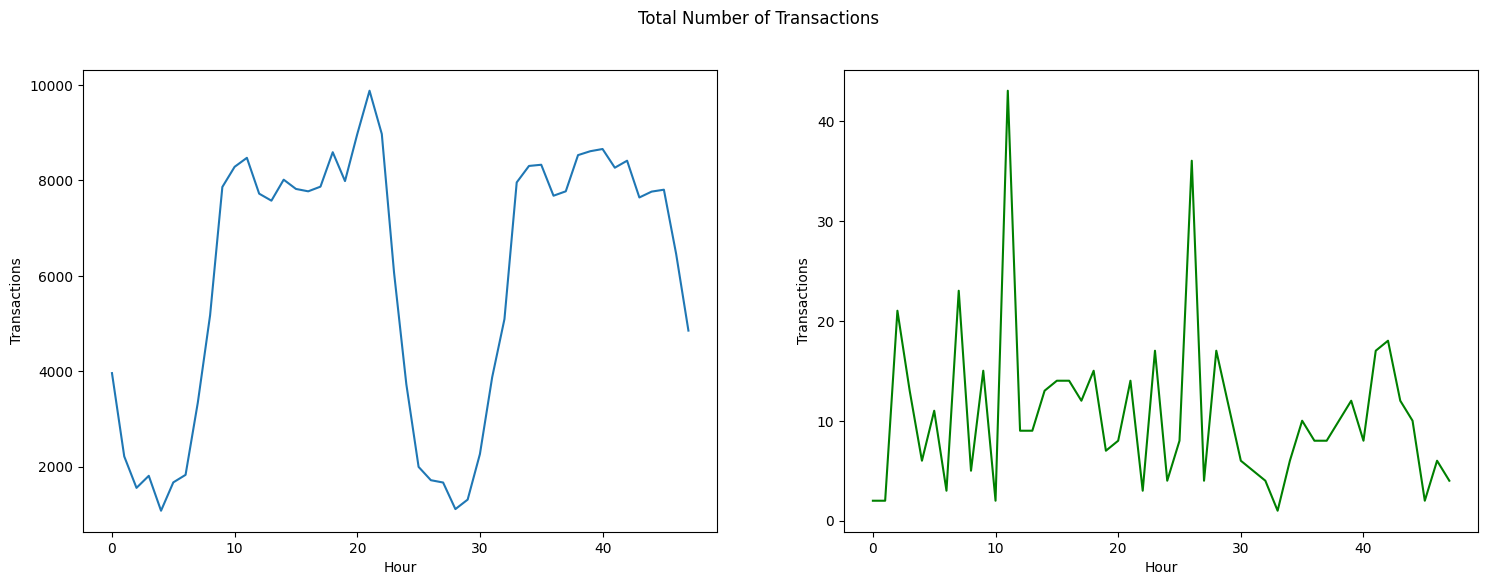

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="green")
plt.suptitle("Total Number of Transactions")
plt.show();

- Left Graph (Non-fraudulent): This graph depicts the total number of transactions over time. It follows a similar pattern to the total amount graph, with higher transaction volumes at certain hours, indicating typical business hours.
- Right Graph (Fraudulent): This graph shows the total number of fraudulent transactions over time. Like the amount graph, it exhibits a more erratic pattern, with peaks that are not as consistent, suggesting that fraudulent activities are less regular.

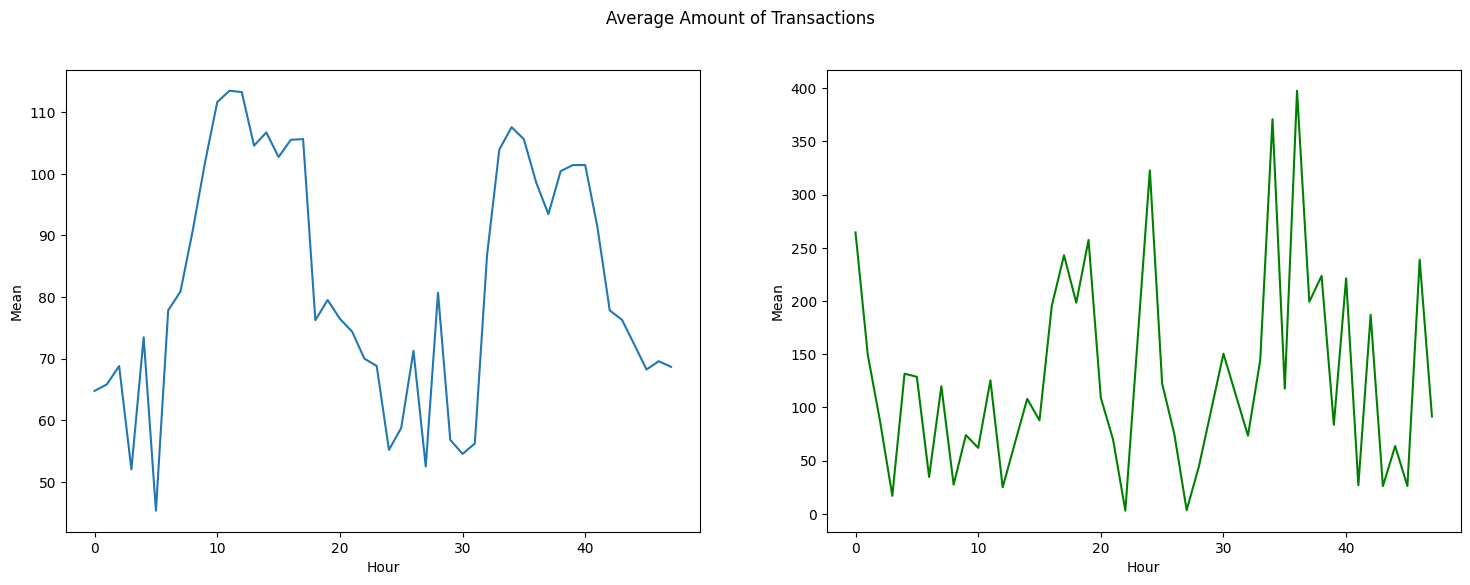

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="green")
plt.suptitle("Average Amount of Transactions")
plt.show();

- Left Graph (Non-fraudulent): This graph represents the average transaction amount over time. The average amount varies, with peaks indicating higher value transactions during specific periods.
- Right Graph (Fraudulent): This graph shows the average transaction amount for fraudulent transactions over time. The pattern is irregular with sharp spikes, indicating occasional high-value fraudulent transactions.

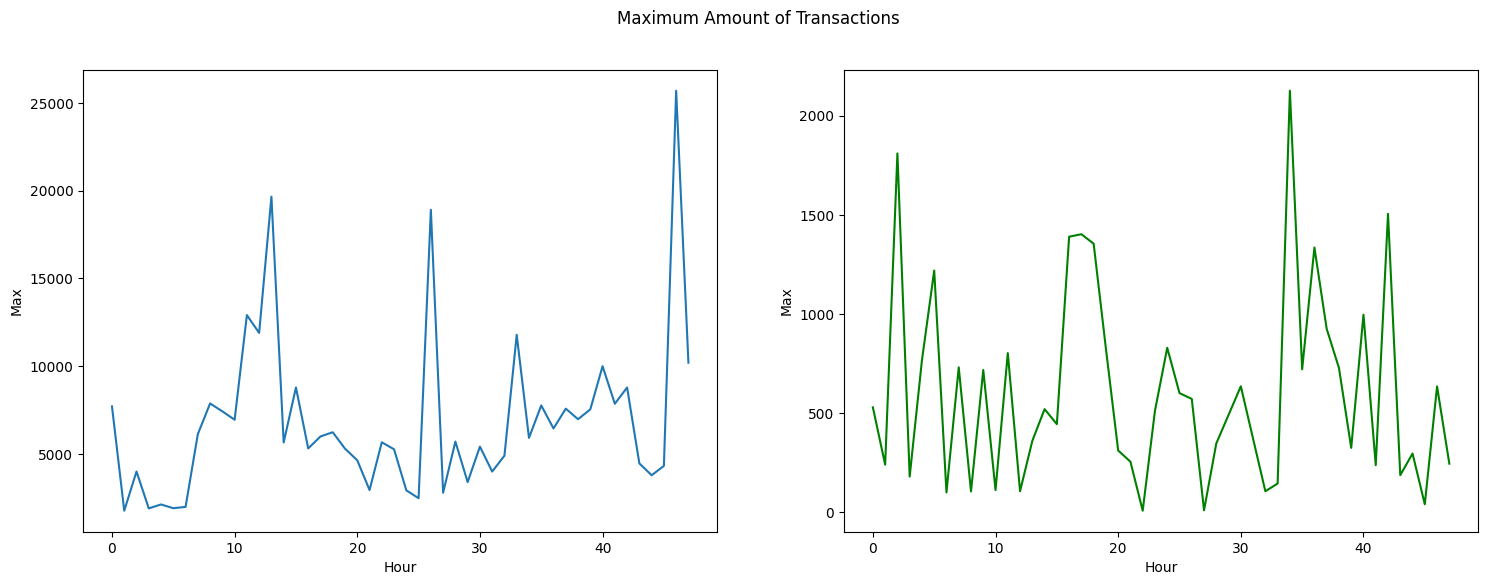

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="green")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

- Left Graph (Non-Fraudulent Maximum Amounts): This graph shows the maximum transaction amounts over time. It displays several peaks up to $25,000, indicating periodic high-value transactions during typical business hours.

- Right Graph (Fraudulent Maximum Amounts): This graph shows the maximum fraudulent transaction amounts over time. It exhibits erratic peaks up to $2000, suggesting unpredictable and sporadic high-value fraudulent activities.

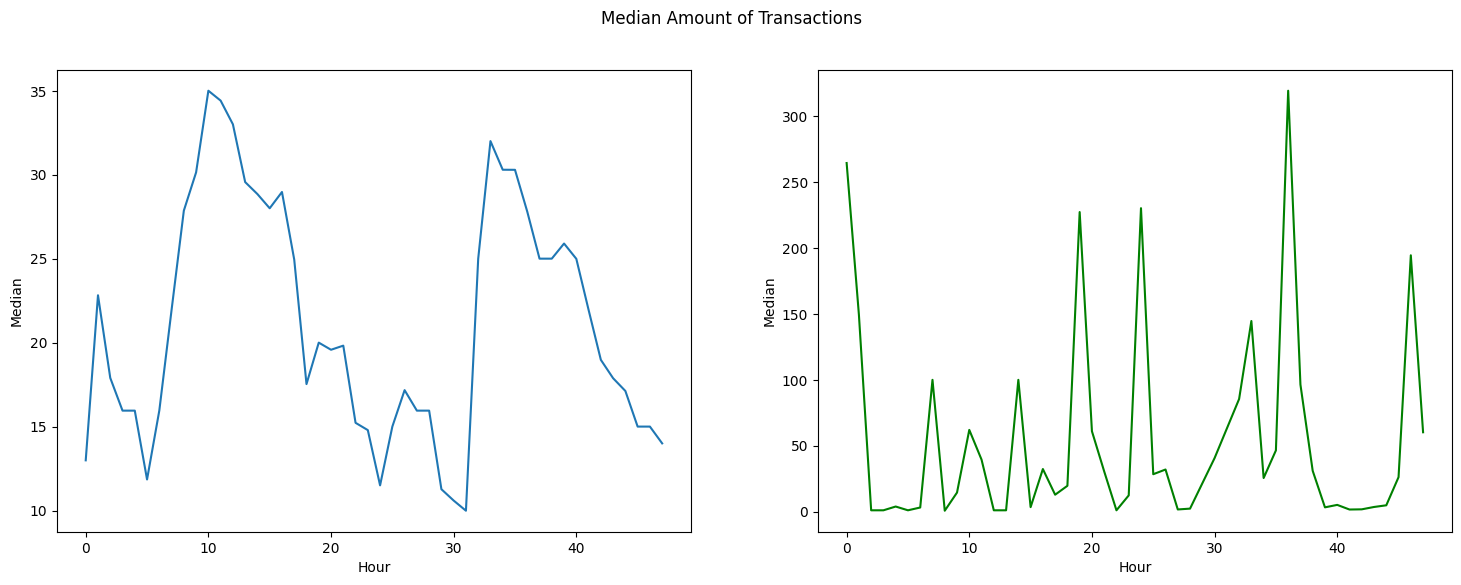

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="green")
plt.suptitle("Median Amount of Transactions")
plt.show();

- Left Graph (Non-Fraudulent Median Amounts): This graph shows the median transaction amounts over time. It is relatively stable, with median values ranging from $10 to $35, indicating consistent transaction behavior.

- Right Graph (Fraudulent Median Amounts): This graph shows the median fraudulent transaction amounts over time. It is highly variable, with many values close to zero and occasional spikes up to $300, reflecting the erratic nature of fraudulent transactions.

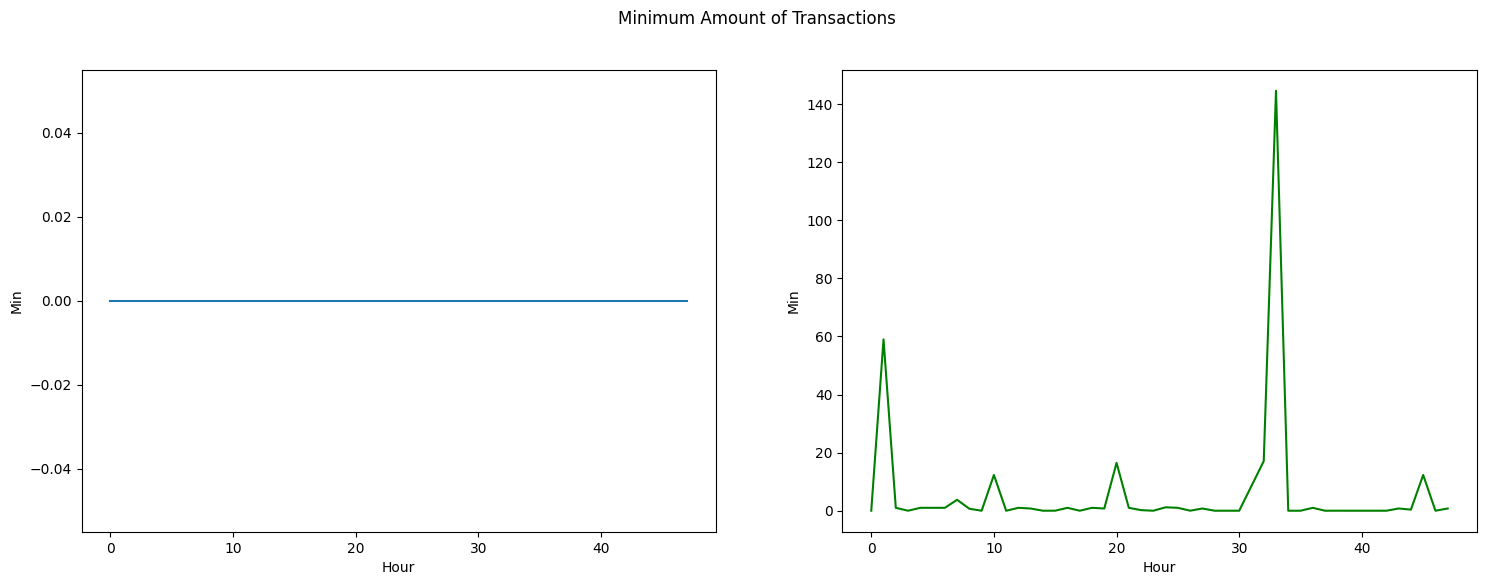

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="green")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

##### Conclude

- Consistency vs. Sporadic Patterns: Non-fraudulent transactions show more consistent patterns in both total amount and number of transactions, likely aligning with typical business hours. In contrast, fraudulent transactions are more sporadic and unpredictable.
- Peak Hours: Non-fraudulent transactions have clear peak hours indicating times of high activity. Fraudulent transactions do not follow this pattern as closely.
- Value of Transactions: While non-fraudulent transactions have a relatively stable average value, fraudulent transactions have a more volatile average value with occasional high spikes, indicating potentially significant fraudulent activities during those spikes.

#### Checking the transaction amount

In [ ]:
tmp = data[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
print("class 0: ", class_0.describe())
print("class 1: ", class_1.describe())

class 0:  count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
class 1:  count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


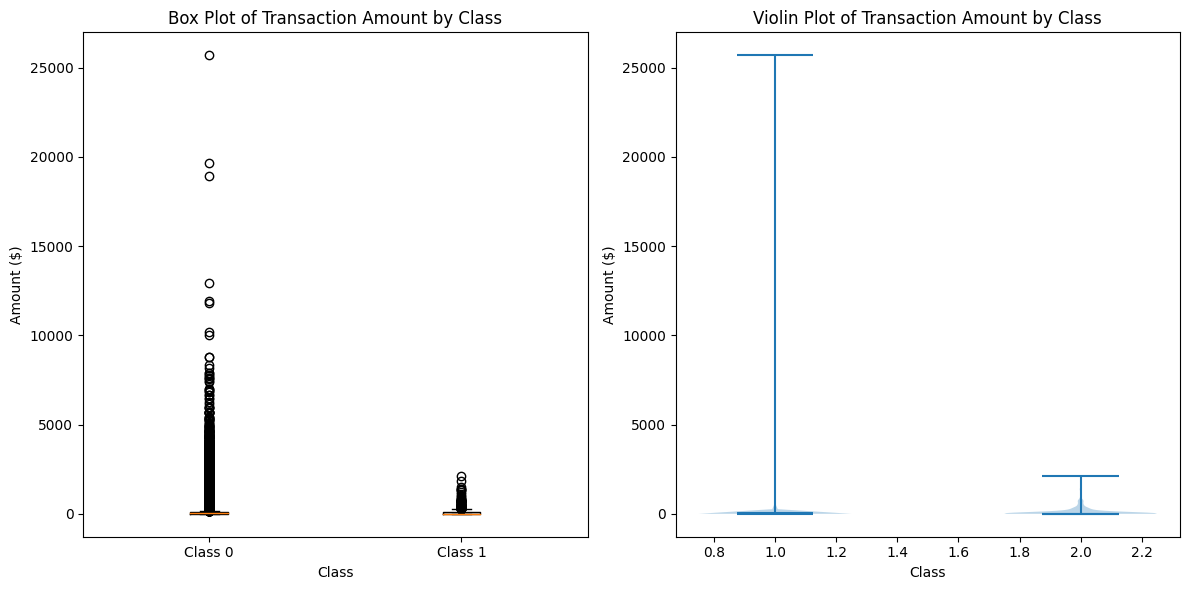

In [ ]:
# Data
tmp = data[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']

# Create a figure and axis object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Box plot
axes[0].boxplot([class_0, class_1], labels=['Class 0', 'Class 1'])
axes[0].set_title('Box Plot of Transaction Amount by Class')
axes[0].set_ylabel('Amount ($)')
axes[0].set_xlabel('Class')

# Violin plot
axes[1].violinplot([class_0, class_1], showmedians=True)
axes[1].set_title('Violin Plot of Transaction Amount by Class')
axes[1].set_ylabel('Amount ($)')
axes[1].set_xlabel('Class')

plt.tight_layout()
plt.show()


Legitimate transactions tend to have a higher average value, a higher first quartile, and more extreme outliers, but a lower third and fourth quartile compared to fraudulent ones. On the other hand, fraudulent transactions show a lower mean and first quartile, a higher fourth quartile, and fewer outliers.

##### Checking amount of fraud data compared to time

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Extract rows where 'Class' is 1 (fraudulent transactions)
fraudulent_transactions = data[data['Class'] == 1]

# Create a scatter plot trace for fraudulent transaction amounts over time
scatter_trace = go.Scatter(
    x=fraudulent_transactions['Time'],  # Time values on the X-axis
    y=fraudulent_transactions['Amount'],  # Transaction Amount values on the Y-axis
    name="Fraudulent Amount",  # Name of the trace
    marker=dict(
        color='rgb(255,127,14)',  # Orange marker color
        line=dict(
            color='rgb(255,69,0)',  # Red-orange border color
            width=1),  # Border width
        opacity=0.6),  # Marker opacity
    text=fraudulent_transactions['Amount'],  # Text for hover info
    mode="markers"  # Only markers are displayed
)

# Create a list of traces
plot_data = [scatter_trace]

# Define the layout of the plot
plot_layout = go.Layout(
    title='Fraudulent Transaction Amounts Over Time',  # Title of the plot
    xaxis=dict(title='Time [seconds]', showticklabels=True),  # X-axis settings
    yaxis=dict(title='Transaction Amount [$]'),  # Y-axis settings
    hovermode='closest'  # Hover mode settings
)

# Create the figure from data and layout
figure = go.Figure(data=plot_data, layout=plot_layout)

# Render the plot
iplot(figure, filename='fraudulent-transaction-amounts')


The scatter plot of fraudulent transaction amounts over time reveals that:

- Sporadic Distribution: Fraudulent transactions are scattered throughout the time range, showing no specific time pattern.
- Variable Amounts: Fraudulent transactions vary widely, with both small amounts and occasional high spikes over $2000.
- Concentration of Small Transactions: Many fraudulent transactions are small, suggesting frequent low-value fraud attempts.
- Periodic High-Value Spikes: There are occasional high-value fraudulent transactions, indicating bursts of significant fraudulent activity.
###### Implications for Model Selection
- Complex Models: Use models like Random Forest, CatBoost, and LightGBM to handle the unpredictable nature and complex interactions.
- Feature Engineering: Focus on transaction amount variability and interactions, as time-based patterns are less useful.

These insights justify the need for sophisticated, flexible models and careful feature engineering to effectively detect fraud.








#### Feature Density plot

<ipython-input-11-69f78627a4ef>:18: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

<ipython-input-11-69f78627a4ef>:19: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



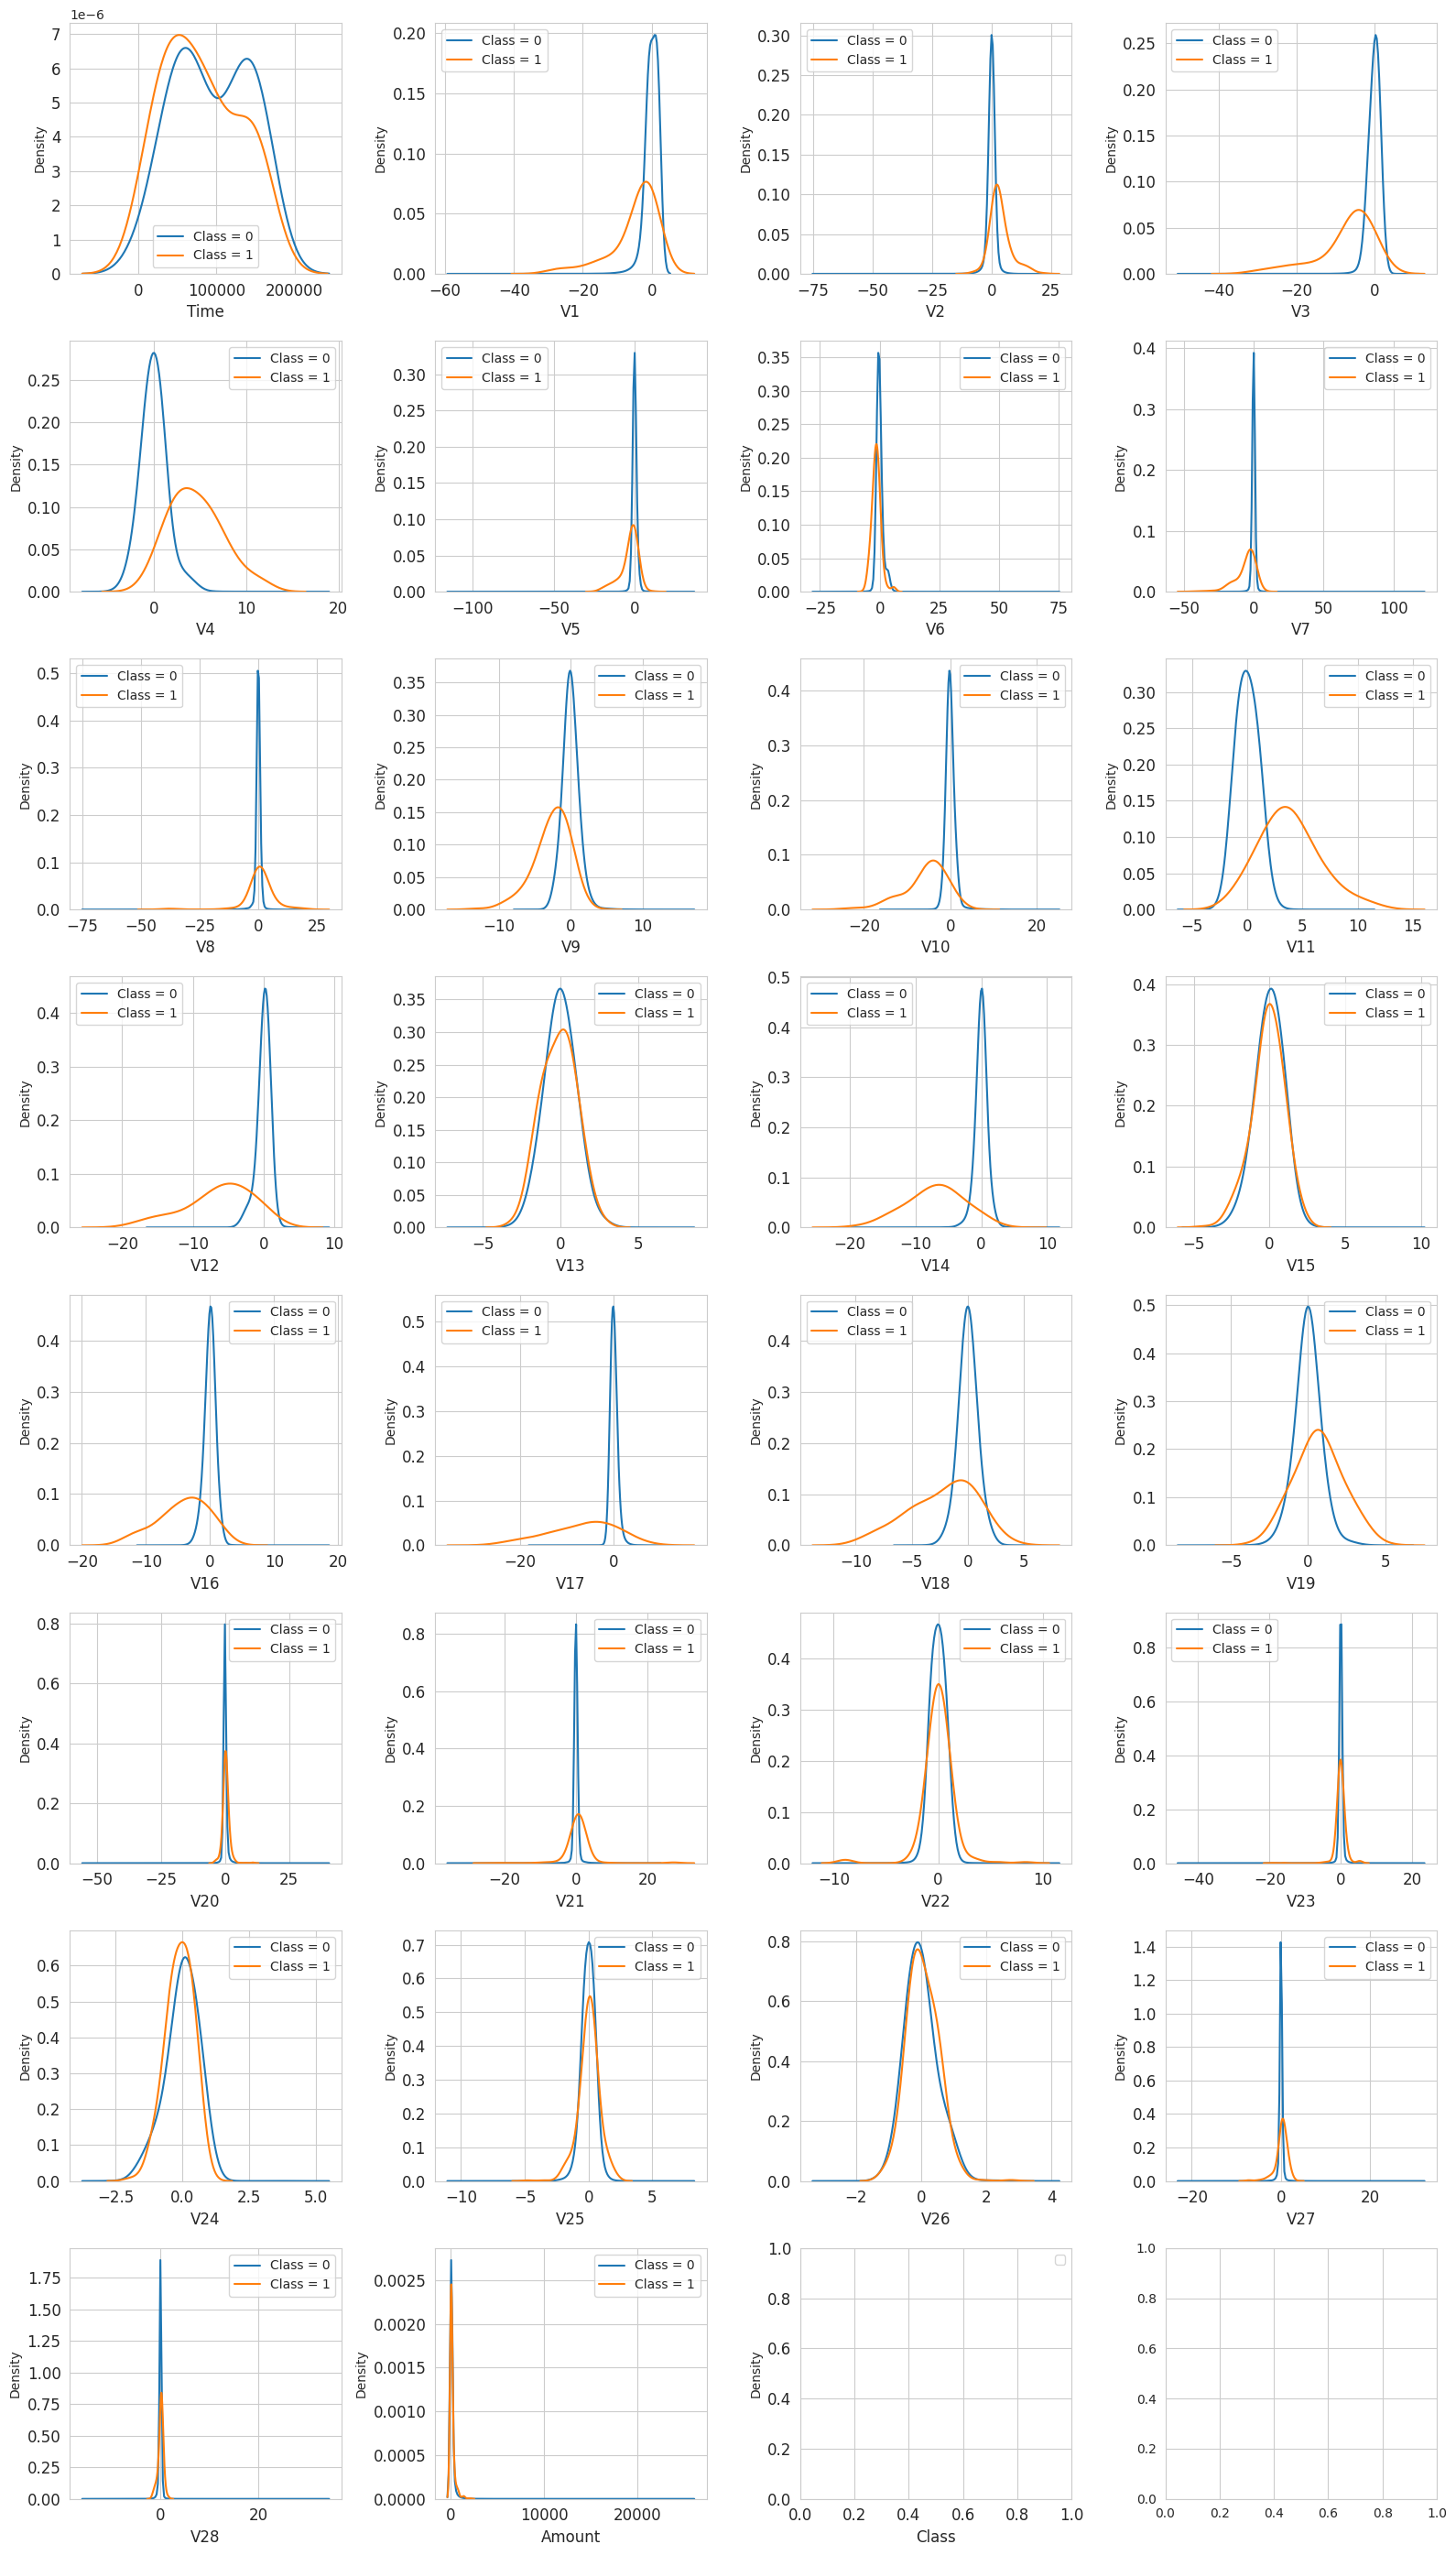

In [ ]:
# Extracting column names
var = data.columns.values

# Splitting data based on class
t0 = data.loc[data['Class'] == 0]
t1 = data.loc[data['Class'] == 1]

# Setting plot style and creating a figure
sns.set_style('whitegrid')
fig, axes = plt.subplots(8, 4, figsize=(16, 28))

# Looping through each feature
for i, feature in enumerate(var):
    row, col = divmod(i, 4)
    ax = axes[row, col]

    # Plotting Kernel Density Estimates for each class
    sns.kdeplot(t0[feature], bw_method=0.5, label="Class = 0", ax=ax)
    sns.kdeplot(t1[feature], bw_method=0.5, label="Class = 1", ax=ax)

    # Adding labels and formatting
    ax.set_xlabel(feature, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


For some features, we can observe good selectivity in terms of distribution for the two class values:

* V4 and V11 have clearly separated distributions for Class 0 and Class 1.
* V12, V14, and V18 show partial separation.
* V1, V2, V3, and V10 have quite distinct profiles.
* V25, V26, and V28 exhibit similar profiles for both class values.

* With a few exceptions (Time and Amount), the distribution of features for legitimate transactions (Class = 0) is centered around 0, sometimes extending into a long tail at one end.
* Fraudulent transactions (Class = 1) tend to have skewed (asymmetric) distributions.

#### Summary

The exploratory data analysis (EDA) of the transaction dataset has revealed several key insights that are critical for developing a robust fraud detection model:
1. **Consistency and Patterns**:
* Non-fraudulent transactions exhibit more consistent patterns in both total amount and number of transactions, aligning with typical business hours.
* Fraudulent transactions are sporadic and unpredictable, without clear peak hours.
2. **Transaction Values**:
* Non-fraudulent transactions have a stable average value.
* Fraudulent transactions show a volatile average value with occasional high spikes, indicating significant fraudulent activities.
3. **Feature Correlations**:
* Most features are weakly to moderately correlated, with principal components (V1-V28) being designed to be uncorrelated due to PCA.
* The Time and Amount features show weak correlations with other variables.
* The target variable (Class) shows low correlation with individual features, suggesting the necessity of combining multiple features for accurate fraud detection.
4. **Feature Distributions**:
* Features like V4, V11, V12, V14, and V18 exhibit good selectivity between fraudulent and non-fraudulent classes. * Legitimate transactions (Class = 0) generally have distributions centered around 0 with long tails.
* Fraudulent transactions (Class = 1) have skewed distributions.
#### Feature Engineering Justification Given that PCA-transformed features (V1-V28) are designed to be uncorrelated and feature independence is beneficial for many machine learning models, no feature removal or additional feature engineering was performed.
Here's why:
* **Preserving Information**: Removing features could lead to a loss of valuable information, especially when dealing with complex patterns in fraud detection.
* **PCA Components**: These components encapsulate the variance in the data effectively, making each feature potentially valuable for the model.
* **Correlation Patterns**: The low correlations between features support the decision to retain all features, as redundant information is minimized.
#### Model Selection Justification Given the insights from the EDA, the following classifiers are recommended due to their ability to handle complex patterns and interactions among features:
1. **Random Forest**:
* **Advantages**: Handles high-dimensional data well, robust to overfitting due to ensemble approach, interpretable feature importance.
* **Suitability**: Can capture non-linear interactions and complex patterns, beneficial for fraud detection where feature interactions are subtle.
2. **Support Vector Machine (SVM)**:
* **Advantages**: Effective in high-dimensional spaces, robust to overfitting with proper regularization, versatile kernel functions.
* **Suitability**: Suitable for datasets where classes are not linearly separable, capable of capturing complex decision boundaries.
3. **CatBoost**:
* **Advantages**: Handles categorical features effectively, fast training, robust to overfitting, supports GPU training.
* **Suitability**: Effective for datasets with categorical features and large datasets, providing high accuracy and efficient training.
4. **Multilayer Perceptron (MLP)**:
* **Advantages**: Can model complex, non-linear relationships, adaptable with different network architectures, suitable for large datasets.
* **Suitability**: Capable of capturing intricate patterns in the data through deep learning architectures, useful for complex fraud detection tasks.
5. **LightGBM**:
* **Advantages**: High efficiency and speed, effective on large datasets, handles missing data, supports categorical features.
* **Suitability**: Provides fast training and high performance, well-suited for large-scale fraud detection problems where quick predictions are essential.
#### Summary
The comprehensive analysis highlights the intricate nature of fraud detection, emphasizing the need for sophisticated models to capture subtle patterns. Retaining all features ensures that no potentially valuable information is lost, while the selected classifiers offer robust, efficient, and accurate detection capabilities. This approach is well-justified given the complexity of fraud patterns and the goal of achieving high detection accuracy.

### Prediction without resampling and handle imbalance using GINI as validation criterion

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [ ]:
from sklearn.model_selection import train_test_split, KFold

VALID_SIZE = 0.20
TEST_SIZE = 0.20

NUMBER_KFOLDS = 5

# Other settings
RANDOM_STATE = 2024
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
IS_LOCAL = False

train_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

#### Random Forest Classifier

In [ ]:
# Pandas settings
pd.set_option('display.max_columns', 100)

# Random Forest Classifier settings
RFC_METRIC = 'gini'  # Metric used for RandomForestClassifier
NUM_ESTIMATORS = 100  # Number of estimators used for RandomForestClassifier
NO_JOBS = 4  # Number of parallel jobs used for RandomForestClassifier

clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])

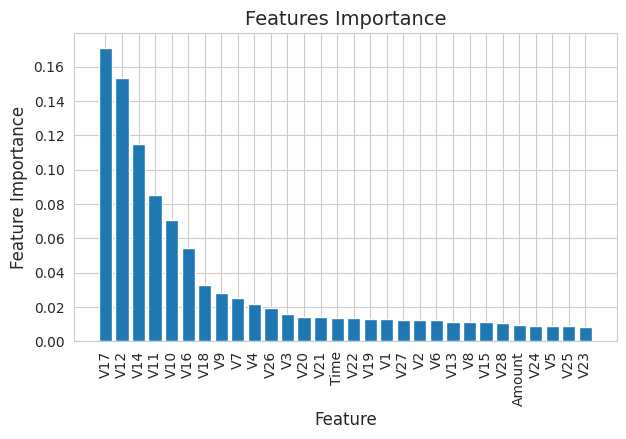

In [ ]:
# Create a DataFrame with feature names and their importance scores
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})

# Sort the DataFrame by feature importance in descending order
tmp = tmp.sort_values(by='Feature importance',ascending=False)

# Create a figure and axis object
plt.figure(figsize = (7,4))

# Plotting the bar chart
plt.bar(tmp['Feature'], tmp['Feature importance'])

# Adding title and labels
plt.title('Features Importance', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

# Rotating x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()


We could see that most important features are V17, V12, V14, V10, V11, V16.

In [ ]:
import plotly.graph_objs as go

cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)
fig = go.Figure(data=[heatmap], layout=layout)

iplot(fig)
# You can hover to see the number

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.9025424478800897
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.93      0.81      0.86        77

    accuracy                           1.00     45569
   macro avg       0.96      0.90      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45487     5]
 [   15    62]]


Using Random Forest Classifier we got AUC as 0.9, which is not bad

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC

# SVM settings
SVC_KERNEL = 'linear'
SVC_C = 1.0

svm_clf = SVC(kernel=SVC_KERNEL, C=SVC_C)

# Train the SVM classifier
svm_clf.fit(train_df[predictors], train_df[target].values)

# Make predictions on the validation set
svm_preds = svm_clf.predict(valid_df[predictors])


In [ ]:
import plotly.graph_objs as go

# Create a DataFrame with the confusion matrix data
cm = pd.crosstab(valid_df[target].values, svm_preds, rownames=['Actual'], colnames=['Predicted'])

# Define the data trace for the heatmap
heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',  # Set the color scale
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)

# Create the figure object
fig = go.Figure(data=[heatmap], layout=layout)

# Render the plot
iplot(fig)


In [ ]:
roc_auc_score(valid_df[target].values, svm_preds)

0.5

#### CatBoost Classifier

In [ ]:
catboost = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [ ]:
catboost.fit(train_df[predictors], train_df[target].values,verbose=True)
catboost_preds = catboost.predict(valid_df[predictors])

0:	total: 880ms	remaining: 7m 19s
50:	total: 29.7s	remaining: 4m 21s
100:	total: 52.6s	remaining: 3m 27s
150:	total: 1m 16s	remaining: 2m 56s
200:	total: 1m 41s	remaining: 2m 31s
250:	total: 2m 6s	remaining: 2m 5s
300:	total: 2m 28s	remaining: 1m 37s
350:	total: 2m 52s	remaining: 1m 13s
400:	total: 3m 17s	remaining: 48.6s
450:	total: 3m 39s	remaining: 23.8s
499:	total: 4m 2s	remaining: 0us


<ipython-input-14-e1148afbac45>:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



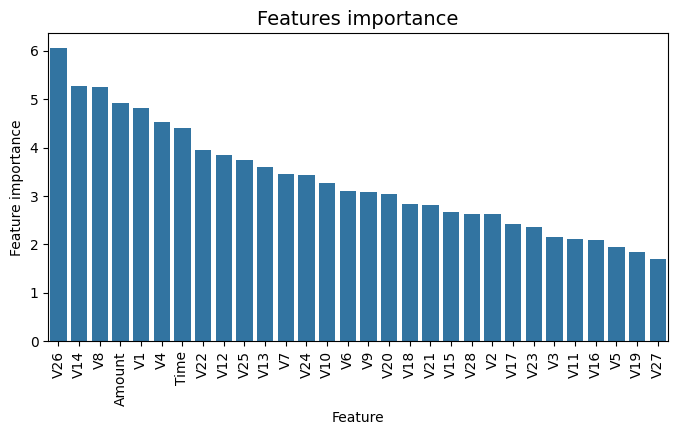

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': catboost.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
import plotly.graph_objs as go

cm = pd.crosstab(valid_df[target].values, catboost_preds, rownames=['Actual'], colnames=['Predicted'])

heatmap = go.Heatmap(z=cm.values,
                     x=['Not Fraud', 'Fraud'],
                     y=['Not Fraud', 'Fraud'],
                     colorscale='Blues',
                     hoverinfo='z'  # Show the actual values on hover
                    )

# Define layout settings
layout = go.Layout(
    title='Confusion Matrix',  # Set the title
    xaxis=dict(title='Predicted'),  # Set the x-axis label
    yaxis=dict(title='Actual'),  # Set the y-axis label
)
fig = go.Figure(data=[heatmap], layout=layout)

iplot(fig)
# You can hover to see the number

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, catboost_preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, catboost_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, catboost_preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.9090469453170589
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.94      0.82      0.88        77

    accuracy                           1.00     45569
   macro avg       0.97      0.91      0.94     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45488     4]
 [   14    63]]


#### Multi Layer Perceptron

In [ ]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(train_df[predictors], train_df[target].values)
MLP_pred = MLPC.predict(valid_df[predictors])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(valid_df[target].values, MLP_pred)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(valid_df[target].values, MLP_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, MLP_pred)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.49997801811307485
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45492
           1       0.00      0.00      0.00        77

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45490     2]
 [   77     0]]


#### LightGBM

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [ ]:
evals_results = {}

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dvalid],
                  valid_names=['train','valid'],
#                   evals_result=evals_results,
                  num_boost_round=MAX_ROUNDS,
#                   early_stopping_round=2*EARLY_STOP,
#                   verbose_eval=VERBOSE_EVAL,
                  feval=None)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

In [ ]:
lgb_preds = model.predict(valid_df[predictors])

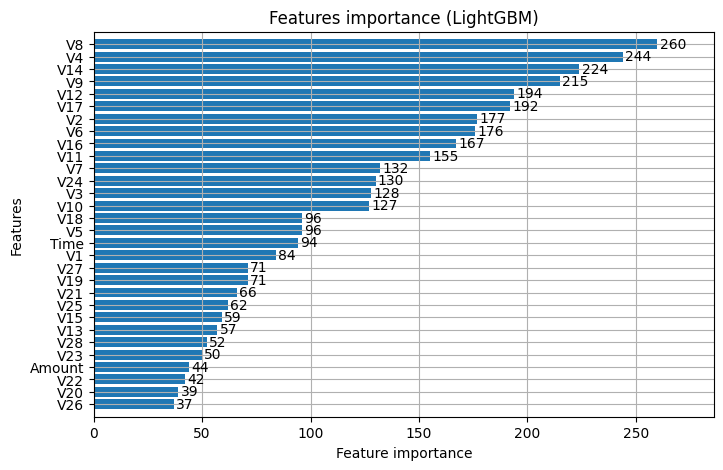

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

roc_auc = roc_auc_score(valid_df[target].values, lgb_preds)
print("ROC AUC Score:", roc_auc)

class_preds = (lgb_preds >= 0.5).astype(int)

class_report = classification_report(valid_df[target].values, class_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(valid_df[target].values, class_preds)
print("Confusion Matrix:")
print(conf_matrix)


ROC AUC Score: 0.79895751614955
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     45492
           1       0.02      0.65      0.04        77

    accuracy                           0.95     45569
   macro avg       0.51      0.80      0.51     45569
weighted avg       1.00      0.95      0.97     45569

Confusion Matrix:
[[43157  2335]
 [   27    50]]


#### Test with test set

Catboost yields the best result, we will test CatBoost with test set

In [ ]:
cb_preds = catboost.predict(test_df[predictors])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

roc_auc = roc_auc_score(test_df[target].values, cb_preds)
print("ROC AUC Score:", roc_auc)

class_report = classification_report(test_df[target].values, cb_preds)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(test_df[target].values, cb_preds)
print("Confusion Matrix:")
print(conf_matrix)

ROC AUC Score: 0.8624736110622427
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56842
           1       0.97      0.72      0.83       120

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56839     3]
 [   33    87]]


We got AUC of 0.86, precesion 0.97, recall 0.72 and f1 score 0.83 as final result.